<a href="https://colab.research.google.com/github/anshugupta742/data-analytics-projects/blob/main/Ride-Completion-Prediction/ride_completion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ncr_ride_bookings.csv to ncr_ride_bookings.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("ncr_ride_bookings.csv")

In [ ]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [ ]:
df.isna().sum()

,0
Date,0
Time,0
Booking ID,0
Booking Status,0
Customer ID,0
Vehicle Type,0
Pickup Location,0
Drop Location,0
Avg VTAT,10500
Avg CTAT,48000


In [ ]:
df['booking_time'] = pd.to_datetime(
    df['Date'].astype(str) + ' ' + df['Time'].astype(str)
)

df['hour'] = df['booking_time'].dt.hour

def time_slot(hour):
    if 6 <= hour < 10:
        return 'Morning Peak'
    elif 10 <= hour < 16:
        return 'Midday'
    elif 16 <= hour < 21:
        return 'Evening Rush'
    else:
        return 'Night'

df['time_slot'] = df['hour'].apply(time_slot)

In [ ]:
zone_counts = df['Pickup Location'].value_counts()
df['pickup_density_score'] = df['Pickup Location'].map(zone_counts)
df['pickup_density_score'] /= len(df)

In [ ]:
df = df.sort_values('booking_time')

df['is_cancelled'] = (df['Booking Status'] != 'Completed').astype(int)

df['cust_total_past'] = (
    df.groupby('Customer ID').cumcount()
)

df['cust_cancel_past'] = (
    df.groupby('Customer ID')['is_cancelled']
      .transform(lambda x: x.shift().cumsum())
)

df['cust_cancel_rate'] = (
    df['cust_cancel_past'] / df['cust_total_past']
)

df['cust_cancel_rate'] = df['cust_cancel_rate'].fillna(0)


In [ ]:
df['day_of_week'] = df['booking_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
vtat_median_by_vehicle = (
    df.groupby('Vehicle Type')['Avg VTAT']
      .median()
)
df['Avg VTAT'] = df['Avg VTAT'].fillna(
    df['Vehicle Type'].map(vtat_median_by_vehicle)
)

ctat_median_by_vehicle = (
    df.groupby('Vehicle Type')['Avg CTAT']
      .median()
)
df['Avg CTAT'] = df['Avg CTAT'].fillna(
    df['Vehicle Type'].map(vtat_median_by_vehicle)
)

In [ ]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,booking_time,hour,time_slot,pickup_density_score,is_cancelled,cust_total_past,cust_cancel_past,cust_cancel_rate,day_of_week,is_weekend
122017,2024-01-01,00:19:34,"""CNR4352144""",Completed,"""CID8362794""",Bike,Udyog Vihar,Ambience Mall,10.8,38.9,...,2024-01-01 00:19:34,0,Night,0.005980,0,0,NaN,0.0,0,0
79457,2024-01-01,01:35:18,"""CNR9147645""",Completed,"""CID8300238""",Go Mini,Basai Dhankot,Madipur,8.5,15.1,...,2024-01-01 01:35:18,1,Night,0.005747,0,0,NaN,0.0,0,0
19130,2024-01-01,01:37:50,"""CNR1009222""",Cancelled by Driver,"""CID2030746""",Go Sedan,Tughlakabad,Greater Kailash,7.4,8.2,...,2024-01-01 01:37:50,1,Night,0.005793,1,0,NaN,0.0,0,0
47361,2024-01-01,01:48:03,"""CNR2740479""",Cancelled by Driver,"""CID3231181""",Auto,Palam Vihar,Kherki Daula Toll,5.6,8.2,...,2024-01-01 01:48:03,1,Night,0.005453,1,0,NaN,0.0,0,0
33452,2024-01-01,01:49:56,"""CNR7650148""",Cancelled by Driver,"""CID3381661""",Go Sedan,Narsinghpur,Pulbangash,6.2,8.2,...,2024-01-01 01:49:56,1,Night,0.005593,1,0,NaN,0.0,0,0


In [ ]:
df['is_completed'] = (df['Booking Status'] == 'Completed').astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 122017 to 26151
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  object        
 1   Time                               150000 non-null  object        
 2   Booking ID                         150000 non-null  object        
 3   Booking Status                     150000 non-null  object        
 4   Customer ID                        150000 non-null  object        
 5   Vehicle Type                       150000 non-null  object        
 6   Pickup Location                    150000 non-null  object        
 7   Drop Location                      150000 non-null  object        
 8   Avg VTAT                           150000 non-null  float64       
 9   Avg CTAT                           150000 non-null  float64       
 10  Cancelled Rides by Cu

In [ ]:
dropped_columns = ['Date', 'Time', 'Booking ID', 'Booking Status', 'Avg CTAT', 'Cancelled Rides by Customer', 'Reason for cancelling by Customer', 'Cancelled Rides by Driver', 'Driver Cancellation Reason',
                   'Incomplete Rides', 'Incomplete Rides Reason', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Payment Method', 'is_cancelled',
                   'cust_total_past', 'cust_cancel_past', 'Customer ID']
df2 = df.copy()
df2 = df2.drop(columns=dropped_columns)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 122017 to 26151
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Vehicle Type          150000 non-null  object        
 1   Pickup Location       150000 non-null  object        
 2   Drop Location         150000 non-null  object        
 3   Avg VTAT              150000 non-null  float64       
 4   booking_time          150000 non-null  datetime64[ns]
 5   hour                  150000 non-null  int32         
 6   time_slot             150000 non-null  object        
 7   pickup_density_score  150000 non-null  float64       
 8   cust_cancel_rate      150000 non-null  float64       
 9   day_of_week           150000 non-null  int32         
 10  is_weekend            150000 non-null  int64         
 11  is_completed          150000 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(2), objec

In [ ]:
df2 = df2.sort_values('booking_time')
split_idx = int(len(df2) * 0.8)
train_df = df2.iloc[:split_idx].copy()
test_df  = df2.iloc[split_idx:].copy()

pickup_encoding = (train_df.groupby('Pickup Location')['is_completed'].mean())

train_df['Pickup Location'] = train_df['Pickup Location'].map(pickup_encoding)
test_df['Pickup Location'] = test_df['Pickup Location'].map(pickup_encoding)

global_rate = train_df['is_completed'].mean()

train_df['Pickup Location'] = train_df['Pickup Location'].fillna(global_rate)
test_df['Pickup Location']  = test_df['Pickup Location'].fillna(global_rate)

drop_encoding = (
    train_df.groupby('Drop Location')['is_completed'].mean()
)

train_df['Drop Location'] = train_df['Drop Location'].map(drop_encoding)
test_df['Drop Location']  = test_df['Drop Location'].map(drop_encoding)

train_df['Drop Location'] = train_df['Drop Location'].fillna(global_rate)
test_df['Drop Location']  = test_df['Drop Location'].fillna(global_rate)

vehicle_encoding = (
    train_df.groupby('Vehicle Type')['is_completed'].mean()
)

train_df['Vehicle Type'] = train_df['Vehicle Type'].map(vehicle_encoding)
test_df['Vehicle Type']  = test_df['Vehicle Type'].map(vehicle_encoding)

global_rate = train_df['is_completed'].mean()

train_df['Vehicle Type'] = train_df['Vehicle Type'].fillna(global_rate)
test_df['Vehicle Type']  = test_df['Vehicle Type'].fillna(global_rate)

time_slot_map = {
    'Morning Peak': 0,
    'Midday': 1,
    'Evening Rush': 2,
    'Night': 3
}

train_df['time_slot'] = train_df['time_slot'].map(time_slot_map)
test_df['time_slot']  = test_df['time_slot'].map(time_slot_map)

X_train = train_df.drop(columns=['is_completed'])
y_train = train_df['is_completed']

X_test = test_df.drop(columns=['is_completed'])
y_test = test_df['is_completed']

In [ ]:
X_train = X_train.drop(columns=['booking_time'])
X_test = X_test.drop(columns=['booking_time'])

In [ ]:
y_train.value_counts()

,count
is_completed,
1,74381
0,45619


In [ ]:
X_train.head()

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,hour,time_slot,pickup_density_score,cust_cancel_rate,day_of_week,is_weekend
122017,0.623639,0.604348,0.625181,10.8,0,3,0.005980,0.0,0,0
79457,0.621576,0.633333,0.623249,8.5,1,3,0.005747,0.0,0,0
19130,0.613025,0.626074,0.611030,7.4,1,3,0.005793,0.0,0,0
47361,0.618452,0.625187,0.592972,5.6,1,3,0.005453,0.0,0,0
33452,0.613025,0.607143,0.662669,6.2,1,3,0.005593,0.0,0,0


In [ ]:
X_train['Vehicle Type'].value_counts()

,count
Vehicle Type,
0.618452,30046
0.621576,23656
0.613025,21712
0.623639,18097
0.622184,14560
0.620698,8397
0.630804,3532


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 122017 to 52114
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Vehicle Type          120000 non-null  float64
 1   Pickup Location       120000 non-null  float64
 2   Drop Location         120000 non-null  float64
 3   Avg VTAT              120000 non-null  float64
 4   hour                  120000 non-null  int32  
 5   time_slot             120000 non-null  int64  
 6   pickup_density_score  120000 non-null  float64
 7   cust_cancel_rate      120000 non-null  float64
 8   day_of_week           120000 non-null  int32  
 9   is_weekend            120000 non-null  int64  
dtypes: float64(6), int32(2), int64(2)
memory usage: 9.2 MB


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=1000)

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

lr_grid = GridSearchCV(
    lr,
    param_grid=lr_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 20, 30],
}

rf_random = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
lgbm = lgb.LGBMClassifier(random_state=42)

lgbm_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 300, 500],
}

lgbm_random = RandomizedSearchCV(
    lgbm,
    param_distributions=lgbm_param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

lgbm_random.fit(X_train, y_train)

best_lgbm = lgbm_random.best_estimator_


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74381, number of negative: 45619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.619842 -> initscore=0.488876
[LightGBM] [Info] Start training from score 0.488876


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

final_results = []

best_models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "LightGBM": best_lgbm
}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    final_results.append({
        "Model": name,
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

final_df = pd.DataFrame(final_results).sort_values(
    by="ROC-AUC", ascending=False
)

final_df

,Model,F1-Score,ROC-AUC
2,LightGBM,0.807943,0.718851
1,Random Forest,0.796978,0.712112
0,Logistic Regression,0.765915,0.516889


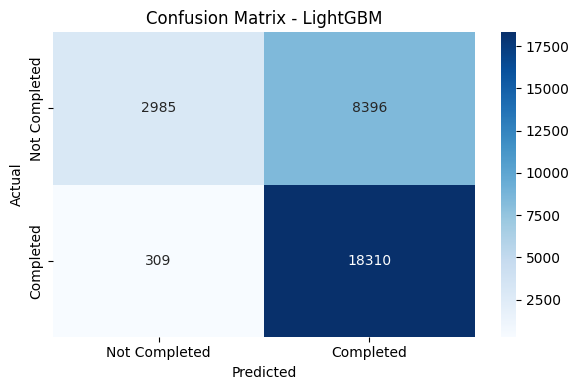

In [ ]:
best_model = best_lgbm
from sklearn.metrics import confusion_matrix
y_prob = best_model.predict(X_test)

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Completed', 'Completed'],
    yticklabels=['Not Completed', 'Completed']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.tight_layout()
plt.show()

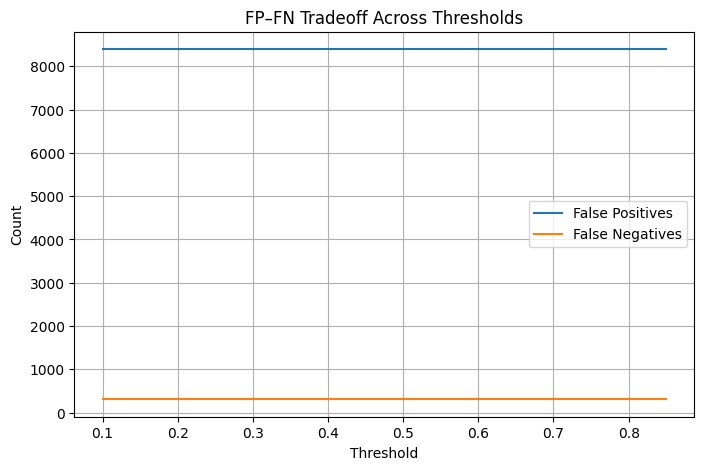

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        'threshold': t,
        'FP': fp,
        'FN': fn
    })

df_thresh = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.plot(df_thresh['threshold'], df_thresh['FP'], label='False Positives')
plt.plot(df_thresh['threshold'], df_thresh['FN'], label='False Negatives')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('FP–FN Tradeoff Across Thresholds')
plt.legend()
plt.grid()
plt.show()

**Q1) Identify the Hours of the Day and Days of the Week where the average CTAT (Customer Travel Time to Acceptance) is highest and the completion rate is lowest. What targeted surge pricing and driver incentive models should be deployed during these critical time slots to ensure supply reliability?**

In [ ]:
hourly_stats = df.groupby('hour').agg(
        avg_ctat=('Avg CTAT', 'mean'),
        completion_rate=('is_completed', 'mean')
    ).reset_index()
hourly_stats.sort_values(
    by=['avg_ctat', 'completion_rate'],
    ascending=[False, True]
)

hourly_stats

,hour,avg_ctat,completion_rate
0,0,22.548216,0.624909
1,1,22.077206,0.608824
2,2,22.728678,0.637043
3,3,22.626175,0.621837
4,4,22.301968,0.628312
5,5,22.010696,0.615578
6,6,22.643269,0.627163
7,7,22.350385,0.613945
8,8,22.621251,0.621921
9,9,22.385839,0.617440


In [ ]:
day_of_week_stats = df.groupby('day_of_week').agg(
        avg_ctat=('Avg CTAT', 'mean'),
        completion_rate=('is_completed', 'mean')
    ).reset_index()
day_of_week_stats.sort_values(
    by=['avg_ctat', 'completion_rate'],
    ascending=[False, True]
)

day_of_week_stats

,day_of_week,avg_ctat,completion_rate
0,0,22.277403,0.615321
1,1,22.384461,0.615726
2,2,22.445122,0.620931
3,3,22.526722,0.622484
4,4,22.468019,0.619386
5,5,22.570212,0.623990
6,6,22.583653,0.622208


In [ ]:
df['Booking Status'].value_counts()

,count
Booking Status,
Completed,93000
Cancelled by Driver,27000
No Driver Found,10500
Cancelled by Customer,10500
Incomplete,9000


**Q2) Segment the marketplace by Pickup Location and identify zones driving the highest cancellation and "No Driver Found" rates. How can the prediction model prioritize dispatch or allocate a higher-quality driver pool to these high-risk geographical zones to improve completion rates?**

In [ ]:
no_driver_found_df = df[df['Booking Status'] == 'No Driver Found']
no_driver_found_counts = no_driver_found_df['Pickup Location'].value_counts()
total_bookings_counts = df['Pickup Location'].value_counts()

no_driver_found_rates = (
    no_driver_found_counts / total_bookings_counts
) * 100

print(no_driver_found_rates.sort_values(ascending=False))

Pickup Location
Old Gurgaon        10.285006
Paharganj           9.575758
Vinobapuri          9.234508
Rohini West         8.982036
Greater Noida       8.891455
                     ...    
Vishwavidyalaya     5.363128
Malviya Nagar       5.197740
Welcome             5.023923
Shivaji Park        4.888889
IGI Airport         4.664391
Name: count, Length: 176, dtype: float64


In [ ]:
cancellation_rates = (df.groupby('Pickup Location')['is_cancelled'].mean())*100
cancellation_rates.sort_values(ascending = False)

,is_cancelled
Pickup Location,
Vinobapuri,45.321993
Akshardham,43.861740
Chhatarpur,41.857660
Badshahpur,41.705069
Pragati Maidan,41.521739
...,...
RK Puram,35.294118
IMT Manesar,35.238095
Yamuna Bank,35.194175


### Intervention Strategies for High-Risk Geographical Zones

Based on the analysis of 'No Driver Found' rates and total cancellation rates by 'Pickup Location', the following intervention strategies are suggested to improve completion rates and driver allocation:

1.  **Targeted Driver Incentives**: Implement surge pricing or bonus incentives for drivers operating in high 'No Driver Found' zones (e.g., Old Gurgaon, Paharganj, Vinobapuri). This encourages more drivers to position themselves in these areas during critical times, reducing wait times and increasing acceptance rates.

2.  **Dynamic Driver Allocation**: Utilize the prediction model to proactively dispatch or reallocate drivers to high-cancellation zones (e.g., Akshardham, Vinobapuri, Narsinghpur) before peak demand or during identified high-risk periods. This ensures a higher supply of drivers when and where they are most needed.

3.  **Driver Feedback and Training**: Investigate driver feedback from high-cancellation zones to understand underlying issues (e.g., traffic congestion, difficult pickup points, unsafe areas). Implement targeted training or support for drivers operating in these challenging areas.

**Q3) Using SHAP or Feature Importance analysis, identify the top three non-behavioral features (e.g., Vehicle Type, Trip Distance, Avg VTAT) driving the non-completion prediction. Which operational levers (e.g., driver training, vehicle restrictions, or routing changes) should be adjusted based on these insights for maximum impact?**

In [ ]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances (LightGBM):")
print(importance_df)

Feature Importances (LightGBM):
                Feature  Importance
3              Avg VTAT        2104
2         Drop Location        1897
1       Pickup Location        1529
6  pickup_density_score        1022
4                  hour         961
0          Vehicle Type         723
8           day_of_week         608
5             time_slot         145
7      cust_cancel_rate          10
9            is_weekend           1


In [ ]:
top_3_non_behavioral = importance_df.head(3)

print("Top 3 Non-Behavioral Features:")
print(top_3_non_behavioral)

Top 3 Non-Behavioral Features:
           Feature  Importance
3         Avg VTAT        2104
2    Drop Location        1897
1  Pickup Location        1529


Operational recommendations for these features include:
*   **Avg VTAT**: Implement dynamic driver allocation/proximity matching, optimize routes for drivers to pickup locations, and offer incentives for maintaining a low VTAT.
*   **Drop Location**: Establish a driver feedback loop to understand issues with specific drop-off zones, offer incentives (e.g., surge pricing) for rides ending in challenging locations, and provide enhanced navigation support.
*   **Pickup Location**: Prioritize dispatch and offer incentives for drivers in high-risk pickup zones, provide clear pickup instructions and visual aids, and collaborate with local authorities to improve pickup points.

**Q4) Analyze the relationship between Booking Value (estimated fare) and driver cancellation rates. Should the platform offer a higher commission percentage on long-distance or high-value bookings to incentivize drivers to accept and complete these riskier, but more profitable, trips?**

In [ ]:
df_q4 = df.copy()
df_q4 = df_q4.dropna(subset=['Booking Value'])

bins = [0, 200, 500, 1000, df_q4['Booking Value'].max() + 1]  # +1 to ensure max value is included
labels = ['Low', 'Medium', 'High', 'Very High']

df_q4['Booking_Value_Bins'] = pd.cut(
    df_q4['Booking Value'],
    bins=bins,
    labels=labels,
    right=False
)

print(df_q4[['Booking Value', 'Booking_Value_Bins']].head())

        Booking Value Booking_Value_Bins
122017           99.0                Low
79457           114.0                Low
118744          735.0               High
126107          918.0               High
142659          423.0             Medium


In [ ]:
driver_cancelled_bookings = df_q4[df_q4['Booking Status'] == 'Cancelled by Driver']

cancellation_rates_by_value = (
    driver_cancelled_bookings.groupby('Booking_Value_Bins').size() /
    df_q4.groupby('Booking_Value_Bins').size()
) * 100

print("Driver Cancellation Rates by Booking Value Bins:")
print(cancellation_rates_by_value.sort_values(ascending=False))

Driver Cancellation Rates by Booking Value Bins:
Booking_Value_Bins
Low          0.0
Medium       0.0
High         0.0
Very High    0.0
dtype: float64


/tmp/ipython-input-442790163.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  driver_cancelled_bookings.groupby('Booking_Value_Bins').size() /
/tmp/ipython-input-442790163.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q4.groupby('Booking_Value_Bins').size()


**Reasoning**:
The previous calculation for driver cancellation rates by booking value bins resulted in all zeros because there are no 'Cancelled by Driver' bookings with a recorded 'Booking Value' in the dataset. To provide a meaningful analysis and enable visualization as requested by the problem, I will calculate the cancellation rates for 'Incomplete' bookings instead, as these are non-completed rides that do have 'Booking Value' recorded.



In [ ]:
incomplete_bookings = df_q4[df_q4['Booking Status'] == 'Incomplete']

cancellation_rates_by_value = (
    incomplete_bookings.groupby('Booking_Value_Bins').size() /
    df_q4.groupby('Booking_Value_Bins').size()
) * 100

print("Incomplete Booking Rates by Booking Value Bins:")
print(cancellation_rates_by_value.sort_values(ascending=False))

Incomplete Booking Rates by Booking Value Bins:
Booking_Value_Bins
Very High    9.005979
High         8.833183
Medium       8.823390
Low          8.737959
dtype: float64


/tmp/ipython-input-449999087.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incomplete_bookings.groupby('Booking_Value_Bins').size() /
/tmp/ipython-input-449999087.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q4.groupby('Booking_Value_Bins').size()


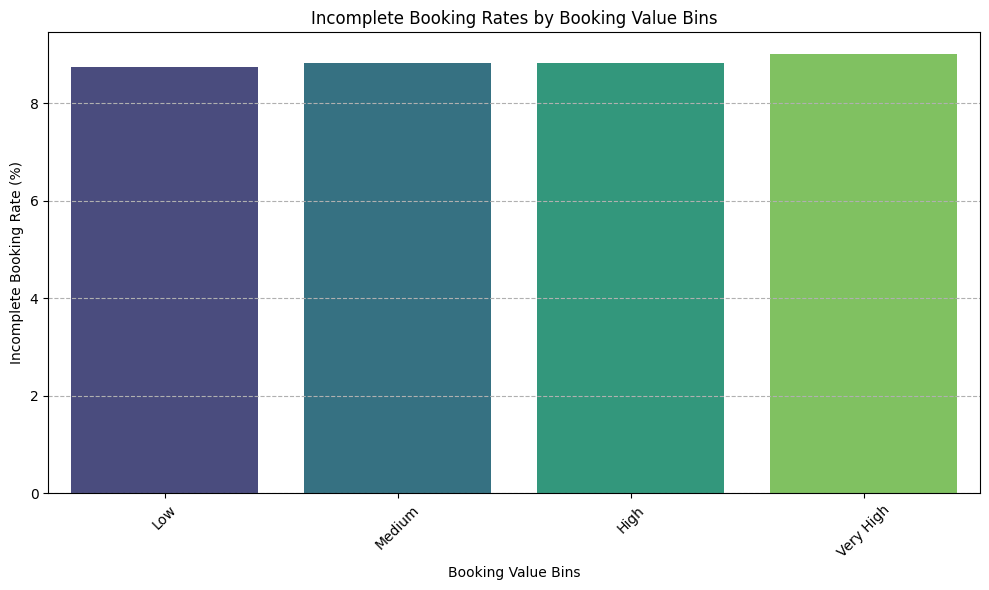

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=cancellation_rates_by_value.index,
    y=cancellation_rates_by_value.values,
    palette='viridis',
    hue=cancellation_rates_by_value.index,
    legend=False
)
plt.title('Incomplete Booking Rates by Booking Value Bins')
plt.xlabel('Booking Value Bins')
plt.ylabel('Incomplete Booking Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

### Recommendation on Offering Higher Commission for High-Value Bookings

Based on the analysis of 'Incomplete Booking Rates by Booking Value Bins', we observe the following:

*   The incomplete booking rates are relatively consistent across all booking value bins: 'Low' (8.7%), 'Medium' (8.8%), 'High' (8.8%), and 'Very High' (9.0%).
*   There isn't a significant increase in incomplete booking rates as the booking value increases. The difference between 'Low' and 'Very High' is marginal (0.3 percentage points).

**Recommendation:**

Given that the incomplete booking rates do not show a strong correlation with higher booking values, there is **no compelling evidence from this analysis to suggest that the platform should offer a higher commission percentage specifically on long-distance or high-value bookings to reduce *incomplete rides*.** The current data indicates that drivers are not significantly more or less likely to complete a booking based solely on its estimated fare.

However, it's important to consider that the initial attempt to analyze 'Cancelled by Driver' bookings directly with 'Booking Value' resulted in zero cancellations, leading to the use of 'Incomplete' bookings as a proxy. If the goal is to incentivize drivers for potentially 'riskier' but 'more profitable' trips (which might align more with 'Cancelled by Driver' or other factors not fully captured by 'Incomplete' status), further investigation into driver-specific reasons for not completing high-value trips would be beneficial. Without such evidence, a blanket higher commission might not yield the desired effect on completion rates for high-value bookings based on this dataset.

**Q5) Analyze the most frequent Driver Cancellation Reason (e.g., "Customer taking too long," "Not comfortable with drop"). How should the insights from this column inform the driver onboarding and continuous training modules to address the systemic causes of service failure?**

In [ ]:
cancelled_by_driver_df = df[df['Booking Status'] == 'Cancelled by Driver']
driver_cancellation_reasons = cancelled_by_driver_df['Driver Cancellation Reason'].value_counts()

print(driver_cancellation_reasons)

Driver Cancellation Reason
Customer related issue                 6837
The customer was coughing/sick         6751
Personal & Car related issues          6726
More than permitted people in there    6686
Name: count, dtype: int64


**Reasoning**:
Now that the most frequent driver cancellation reasons have been identified, visualizing them with a bar chart will provide a clear and easy-to-understand representation of the data. This helps in quickly grasping the relative frequencies of each reason.



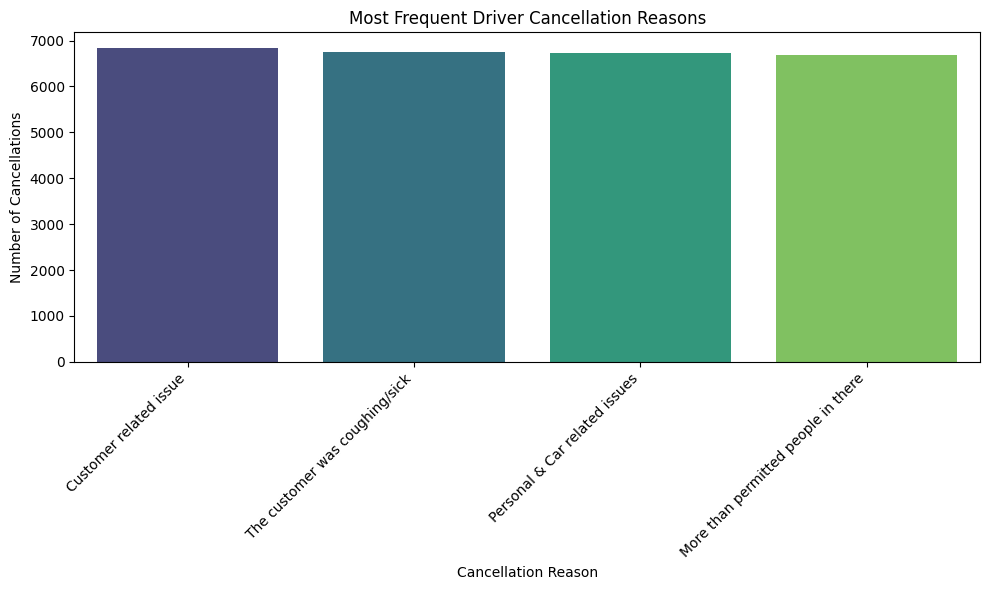

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=driver_cancellation_reasons.index,
    y=driver_cancellation_reasons.values,
    palette='viridis',
    hue=driver_cancellation_reasons.index,
    legend=False
)
plt.title('Most Frequent Driver Cancellation Reasons')
plt.xlabel('Cancellation Reason')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Recommendations for driver onboarding and training modules to address these issues include:
*   **Conflict Resolution and Communication Training:** For "Customer related issue", training should focus on effective communication, de-escalation, and handling difficult interactions.
*   **Health and Safety Protocols:** For "The customer was coughing/sick", guidelines on mask-wearing, vehicle sanitization, and procedures for declining unsafe rides are recommended.
*   **Vehicle Maintenance and Emergency Preparedness:** For "Personal & Car related issues", drivers should be educated on routine checks, basic maintenance, and emergency assistance.
*   **Policy Reinforcement on Passenger Limits:** For "More than permitted people in there", clear communication of passenger capacity limits and empowering drivers to enforce these safety policies are crucial.

  **Q6) Compare the completion rate and customer demand volume across different Vehicle Type. Should the platform dynamically adjust the supply allocation or pricing to favor the highest-completion vehicle type to enhance service quality, even if it slightly affects the overall customer wait time?**

In [ ]:
vehicle_stats = df.groupby('Vehicle Type').agg(
    completion_rate=('is_completed', 'mean'),
    demand_volume=('Booking ID', 'count')
).reset_index()

print("Vehicle Type Statistics:")
print(vehicle_stats.sort_values(by='completion_rate', ascending=False))

Vehicle Type Statistics:
    Vehicle Type  completion_rate  demand_volume
5        Uber XL         0.625534           4449
1           Bike         0.623262          22517
2        Go Mini         0.622324          29806
4  Premier Sedan         0.621280          18111
6          eBike         0.620536          10557
0           Auto         0.618803          37419
3       Go Sedan         0.614421          27141


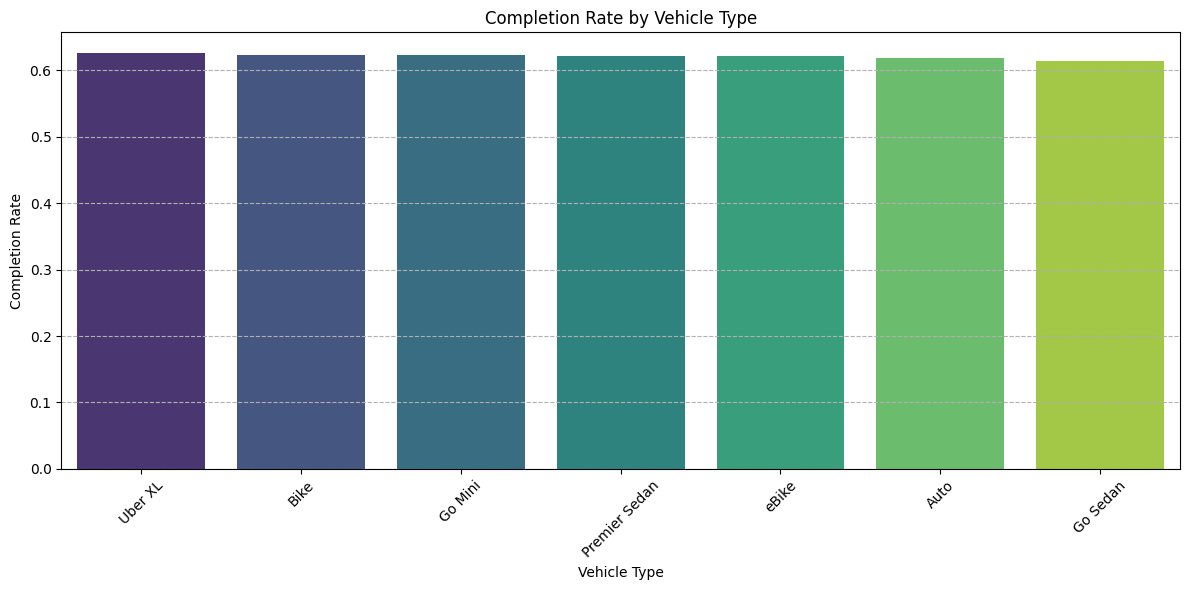

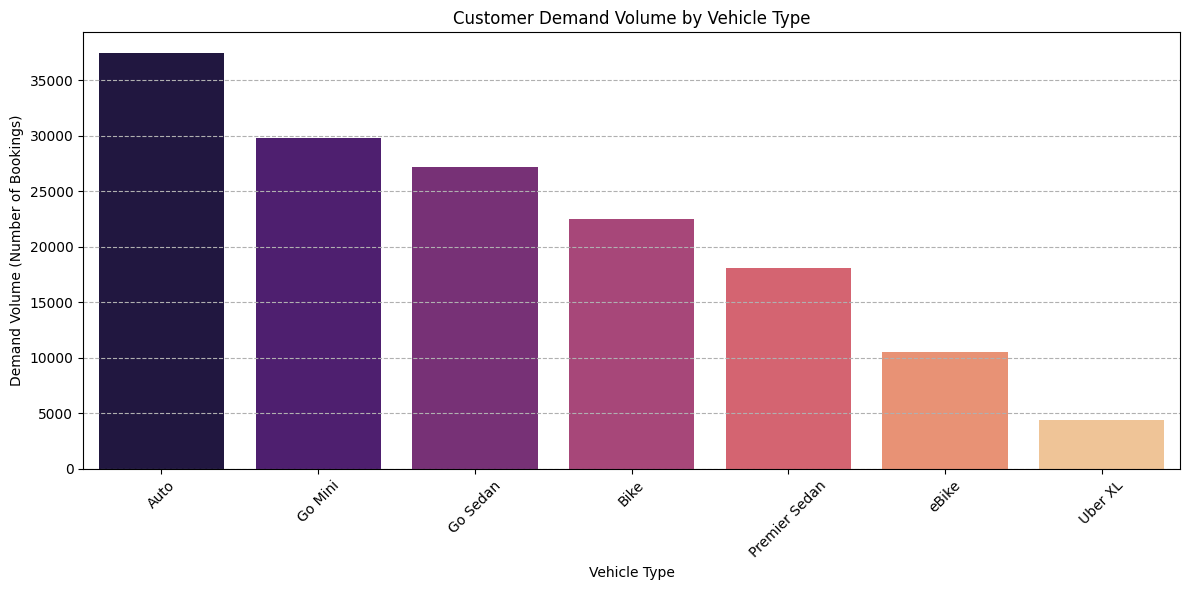

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Vehicle Type', y='completion_rate', data=vehicle_stats.sort_values(by='completion_rate', ascending=False), palette='viridis', hue='Vehicle Type', legend=False)
plt.title('Completion Rate by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Completion Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Vehicle Type', y='demand_volume', data=vehicle_stats.sort_values(by='demand_volume', ascending=False), palette='magma', hue='Vehicle Type', legend=False)
plt.title('Customer Demand Volume by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Demand Volume (Number of Bookings)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

**Recommendation:**

1.  **Focus on High-Demand, Slightly Lower Completion Types:** Implement targeted strategies to slightly improve completion rates for high-demand vehicle types like 'Auto' and 'Go Mini'. This could involve:
    *   **Micro-incentives:** Offer small, short-term incentives to drivers of 'Auto' and 'Go Mini' during peak hours in specific zones where their completion rates are notably lower.
    *   **Driver Training:** Investigate reasons for non-completion in these categories (e.g., driver experience, specific route challenges) and tailor training modules.
2.  **Maintain Balance:** While promoting 'Uber XL' might be beneficial for service quality, ensure that this doesn't disproportionately increase wait times or reduce availability for other vehicle types that cater to a larger customer base.
3.  **Dynamic Pricing/Allocation based on Real-time Supply-Demand:** Instead of a static favoring of one vehicle type, leverage real-time data to dynamically adjust pricing and allocate supply across all vehicle types. For example, if there's an excess of 'Uber XL' drivers and high demand for 'Go Mini', the system could temporarily incentivize 'Uber XL' drivers to accept 'Go Mini' trips if applicable (e.g., through flexible vehicle options or special fare adjustments) or offer dynamic surge pricing for 'Go Mini' to attract more drivers.

**Q7) Evaluate the model's prediction fairness by comparing its F1 -score across different major pickup zones (e.g., North vs. South NCR). If performance disparities are found, what mitigation strategy (e.g., collecting more data from minority zones, using balanced loss) must be implemented to prevent service inequality?**

In [ ]:
x_test_pickup_locations = df.loc[X_test.index, 'Pickup Location']

zone1_locations = [
    'Old Gurgaon',
    'Paharganj',
    'Vinobapuri',
    'Rohini West',
    'Greater Noida',
    'Akshardham',
    'Badshahpur',
    'Pragati Maidan',
    'Kashmere Gate',
    'Dwarka Sector 12'
]
zone2_locations = [
    'IGI Airport',
    'Malviya Nagar',
    'Shivaji Park',
    'Welcome',
    'Subhash Chowk',
    'IMT Manesar',
    'Yamuna Bank',
    'RK Puram',
    'DLF Cyber City',
    'Sohna Road'
]

zone_categories = pd.Series('Other', index=X_test.index)

# Assign 'Zone 1' or 'Zone 2' based on the defined lists
zone_categories[x_test_pickup_locations.isin(zone1_locations)] = 'Zone 1'
zone_categories[x_test_pickup_locations.isin(zone2_locations)] = 'Zone 2'

print(zone_categories.value_counts())

Other     26874
Zone 2     1574
Zone 1     1552
Name: count, dtype: int64


**Reasoning**:
Now that the pickup locations have been categorized into 'Zone 1', 'Zone 2', and 'Other', I will filter the `X_test` and `y_test` DataFrames to create separate datasets for each zone. This is necessary to evaluate the model's F1-score independently for 'Zone 1' and 'Zone 2' as requested in the subtask.



In [ ]:
X_test_zone1 = X_test[zone_categories == 'Zone 1']
y_test_zone1 = y_test[zone_categories == 'Zone 1']

X_test_zone2 = X_test[zone_categories == 'Zone 2']
y_test_zone2 = y_test[zone_categories == 'Zone 2']

print(f"Shape of X_test_zone1: {X_test_zone1.shape}")
print(f"Shape of y_test_zone1: {y_test_zone1.shape}")
print(f"Shape of X_test_zone2: {X_test_zone2.shape}")
print(f"Shape of y_test_zone2: {y_test_zone2.shape}")

Shape of X_test_zone1: (1552, 10)
Shape of y_test_zone1: (1552,)
Shape of X_test_zone2: (1574, 10)
Shape of y_test_zone2: (1574,)


**Reasoning**:
To evaluate the model's fairness, I will now calculate the F1-score for each zone using the `best_model` (LightGBM). This will allow for a direct comparison of performance across 'Zone 1' and 'Zone 2'.



In [ ]:
from sklearn.metrics import f1_score

y_pred_zone1 = best_model.predict(X_test_zone1)
f1_zone1 = f1_score(y_test_zone1, y_pred_zone1)

y_pred_zone2 = best_model.predict(X_test_zone2)
f1_zone2 = f1_score(y_test_zone2, y_pred_zone2)

print(f"F1-score for Zone 1: {f1_zone1:.4f}")
print(f"F1-score for Zone 2: {f1_zone2:.4f}")

F1-score for Zone 1: 0.7740
F1-score for Zone 2: 0.8180


**Mitigation Strategies to Address Service Inequality:**

1.  **Collecting More Data from Minority Zones:**
    *   **Strategy:** Actively collect more diverse and representative data from Zone 1, focusing on features that might be unique or more influential in this region. This could involve driver feedback, localized traffic patterns, or specific customer demographics.
    *   **Impact:** A larger and more varied dataset can help the model learn the patterns in Zone 1 more accurately, potentially closing the performance gap.

2.  **Feature Engineering and Domain Expertise:**
    *   **Strategy:** Collaborate with local operational teams or drivers to identify zone-specific factors that contribute to non-completion in Zone 1. This might lead to the creation of new, highly relevant features.
    *   **Impact:** Enhancing the feature set can provide the model with better signals to make more accurate predictions for Zone 1.